#### Let's take a look at the data

In [1]:
import pandas as pd

In [2]:
URM_path = "data_train.csv"
URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path,
                                sep=",",
                                header=0,
                                dtype={0:int, 1:int, 2:int},
                                engine='python')

URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction"]
# Interaction 1 iff rating >= 4

In [3]:
URM_all_dataframe.head(10)

,UserID,ItemID,Interaction
0,1,7,1
1,1,15,1
2,1,16,1
3,1,133,1
4,1,161,1
5,1,187,1
6,1,205,1
7,1,222,1
8,1,237,1
9,1,354,1


In [4]:
print ("The number of interactions is {}".format(len(URM_all_dataframe)))

The number of interactions is 478730


### Now we can extract the list of unique user id and item id and display some statistics

In [5]:
userID_unique = URM_all_dataframe["UserID"].unique()
itemID_unique = URM_all_dataframe["ItemID"].unique()

In [6]:
n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))

Number of items	 22222, Number of users	 12638
Max ID items	 22347, Max Id users	 13024


### See that the max ID of items and users is higher than the number of unique values -> empty profiles
### We should remove empty indices, to do so we create a new mapping

In [7]:
mapped_id, original_id = pd.factorize(URM_all_dataframe["UserID"].unique())
user_original_ID_to_index = pd.Series(mapped_id, index=original_id)

mapped_id, original_id = pd.factorize(URM_all_dataframe["ItemID"].unique())
item_original_ID_to_index = pd.Series(mapped_id, index=original_id)

URM_all_dataframe["UserID"] = URM_all_dataframe["UserID"].map(user_original_ID_to_index)
URM_all_dataframe["ItemID"] = URM_all_dataframe["ItemID"].map(item_original_ID_to_index)
URM_all_dataframe.head(10)

,UserID,ItemID,Interaction
0,0,0,1
1,0,1,1
2,0,2,1
3,0,3,1
4,0,4,1
5,0,5,1
6,0,6,1
7,0,7,1
8,0,8,1
9,0,9,1


In [8]:
userID_unique = URM_all_dataframe["UserID"].unique()
itemID_unique = URM_all_dataframe["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 22222, Number of users	 12638
Max ID items	 22221, Max Id users	 12637

Average interactions per user 37.88
Average interactions per item 21.54

Sparsity 99.83 %


#### To store the data we use a sparse matrix. We build it as a COO matrix and then change its format

#### The COO constructor expects (data, (row, column))

In [9]:
import scipy.sparse as sps

URM_all = sps.coo_matrix((URM_all_dataframe["Interaction"].values,
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)),
                        shape = (n_users, n_items))

URM_all

<12638x22222 sparse matrix of type '<class 'numpy.int64'>'
	with 478730 stored elements in COOrdinate format>

In [10]:
URM_all.tocsr()

<12638x22222 sparse matrix of type '<class 'numpy.int64'>'
	with 478730 stored elements in Compressed Sparse Row format>

### We compute the item popularity as the number of interaction in each column

### We can use the properties of sparse matrices in CSC format

In [11]:
import numpy as np

item_popularity = np.ediff1d(URM_all.tocsc().indptr)
item_popularity

array([1431, 1007,  754, ...,    1,    1,    1], dtype=int32)

In [12]:
item_popularity = np.sort(item_popularity)
item_popularity

array([   1,    1,    1, ..., 1581, 1666, 1764], dtype=int32)

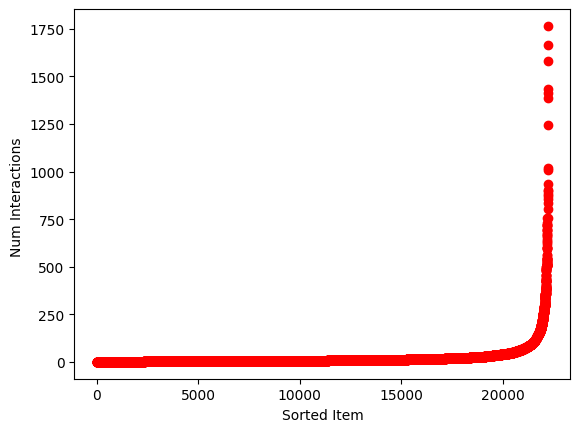

In [13]:
import matplotlib.pyplot as pyplot
pyplot.plot(item_popularity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted Item')
pyplot.show()

In [14]:
ten_percent = int(n_items/10)

print("Average per-item interactions over the whole dataset {:.2f}".
      format(item_popularity.mean()))

print("Average per-item interactions for the top 10% popular items {:.2f}".
      format(item_popularity[-ten_percent:].mean()))

print("Average per-item interactions for the least 10% popular items {:.2f}".
      format(item_popularity[:ten_percent].mean()))

print("Average per-item interactions for the median 10% popular items {:.2f}".
      format(item_popularity[int(n_items*0.45):int(n_items*0.55)].mean()))

Average per-item interactions over the whole dataset 21.54
Average per-item interactions for the top 10% popular items 122.73
Average per-item interactions for the least 10% popular items 2.35
Average per-item interactions for the median 10% popular items 8.37


In [15]:
print("Number of items with zero interactions {}".
      format(np.sum(item_popularity==0)))

Number of items with zero interactions 0


### We compute the user activity (profile length) as the number of interaction in each row

### We can use the properties of sparse matrices in CSR format

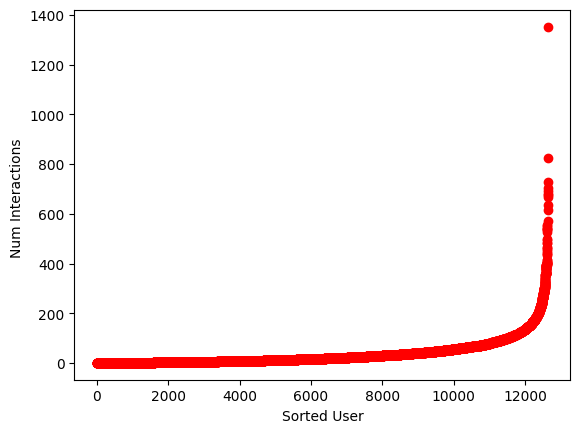

In [16]:
user_activity = np.ediff1d(URM_all.tocsr().indptr)
user_activity = np.sort(user_activity)


pyplot.plot(user_activity, 'ro')
pyplot.ylabel('Num Interactions ')
pyplot.xlabel('Sorted User')
pyplot.show()

In order to evaluate our recommender we have to define:

A splitting of the data in URM_train and URM_test
An evaluation metric
A functon computing the evaluation for each user
The splitting of the data is very important to ensure your algorithm is evaluated in a realistic scenario by using test it has never seen. We create two splits:

- Train data: we will use this to train our model

- Test data: we will use this to evaluate our model

In [17]:
train_test_split = 0.80

n_interactions = URM_all.nnz


train_mask = np.random.choice([True,False], n_interactions, p=[train_test_split, 1-train_test_split])
train_mask

array([ True,  True,  True, ...,  True,  True,  True])

In [18]:
URM_train = sps.csr_matrix((URM_all.data[train_mask],
                            (URM_all.row[train_mask], URM_all.col[train_mask])))

URM_train

<12638x22222 sparse matrix of type '<class 'numpy.int64'>'
	with 383090 stored elements in Compressed Sparse Row format>

In [19]:
test_mask = np.logical_not(train_mask)

URM_test = sps.csr_matrix((URM_all.data[test_mask],
                            (URM_all.row[test_mask], URM_all.col[test_mask])))

URM_test

<12638x22218 sparse matrix of type '<class 'numpy.int64'>'
	with 95640 stored elements in Compressed Sparse Row format>

#### Let's build the recommender

In [20]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10]) 

EvaluatorHoldout: Ignoring 2570 (20.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 2196 (17.4%) Users that have less than 1 test interactions


In [21]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

similarity_object = Compute_Similarity_Python(URM_train, shrink=100.0, 
                                          topK=100,
                                          normalize=True, 
                                          similarity = "cosine")

W_sparse = similarity_object.compute_similarity()
W_sparse

Similarity column 22222 (100.0%), 4868.89 column/sec. Elapsed time 4.56 sec


<22222x22222 sparse matrix of type '<class 'numpy.float32'>'
	with 2108035 stored elements in Compressed Sparse Row format>

In [49]:
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.NonPersonalizedRecommender import TopPop

recommender = PureSVDRecommender(URM_train)
recommender.fit()

top_recommender = TopPop(URM_train)
top_recommender.fit()

PureSVDRecommender: URM Detected 469 ( 3.7%) users with no interactions.
PureSVDRecommender: URM Detected 331 ( 1.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.98 sec
TopPopRecommender: URM Detected 469 ( 3.7%) users with no interactions.
TopPopRecommender: URM Detected 331 ( 1.5%) items with no interactions.


In [50]:
evaluator_test.evaluateRecommender(top_recommender)

EvaluatorHoldout: Processed 10442 (100.0%) in 3.48 sec. Users per second: 3002


(       PRECISION PRECISION_RECALL_MIN_DEN   RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                     
 10       0.02873                 0.053143  0.04577  0.011384    0.021019   
 
              MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                        ...   
 10      0.091625  0.044823  0.035301  0.232331      0.102071  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10          0.826238          0.191961    0.826238       0.000536   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10             3.60392                   0.913235             0.001557   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                      

PureSVDRecommender: URM Detected 469 ( 3.7%) users with no interactions.
PureSVDRecommender: URM Detected 331 ( 1.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.41 sec
EvaluatorHoldout: Processed 10068 (100.0%) in 4.47 sec. Users per second: 2250
PureSVDRecommender: URM Detected 469 ( 3.7%) users with no interactions.
PureSVDRecommender: URM Detected 331 ( 1.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.73 sec
EvaluatorHoldout: Processed 10068 (100.0%) in 4.32 sec. Users per second: 2328
PureSVDRecommender: URM Detected 469 ( 3.7%) users with no interactions.
PureSVDRecommender: URM Detected 331 ( 1.5%) items with no interactions.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 1.00 sec
EvaluatorHoldout: Processed 10068 (100.0%) in 4

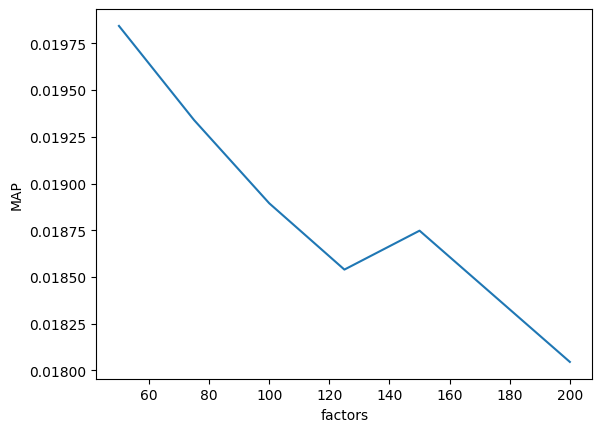

In [24]:
x_tick = [50, 75, 100, 125, 150, 200]
MAP_per_factors = []

for factor in x_tick:
    
    recommender = PureSVDRecommender(URM_train)
    recommender.fit(num_factors=factor)
    
    result_df, _ = evaluator_validation.evaluateRecommender(recommender)
    
    MAP_per_factors.append(result_df.loc[10]["MAP"])

pyplot.plot(x_tick, MAP_per_factors)
pyplot.ylabel('MAP')
pyplot.xlabel('factors')
pyplot.show()

In [25]:
recommender.fit(num_factors=50)
evaluator_test.evaluateRecommender(recommender)

PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 0.66 sec
EvaluatorHoldout: Processed 10442 (100.0%) in 4.67 sec. Users per second: 2237


(       PRECISION PRECISION_RECALL_MIN_DEN    RECALL       MAP MAP_MIN_DEN  \
 cutoff                                                                      
 10      0.050718                 0.088969  0.075073  0.023871    0.042103   
 
              MRR      NDCG        F1  HIT_RATE ARHR_ALL_HITS  ...  \
 cutoff                                                        ...   
 10      0.164656  0.081606  0.060538  0.346868      0.197352  ...   
 
        COVERAGE_USER COVERAGE_USER_HIT USERS_IN_GT DIVERSITY_GINI  \
 cutoff                                                              
 10          0.826238          0.286596    0.826238       0.007284   
 
        SHANNON_ENTROPY RATIO_DIVERSITY_HERFINDAHL RATIO_DIVERSITY_GINI  \
 cutoff                                                                   
 10            7.761488                   0.994219             0.021157   
 
        RATIO_SHANNON_ENTROPY RATIO_AVERAGE_POPULARITY RATIO_NOVELTY  
 cutoff                                   

In [26]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender 
# retrain with full dset

recommender = ItemKNNCFRecommender(URM_all)
recommender.fit(shrink=50.0, topK=10)

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 22222 (100.0%), 4731.85 column/sec. Elapsed time 4.70 sec


In [27]:
import pandas as pd
UserID_path = "data_target_users_test.csv"
URM_all_submission_dataframe = pd.read_csv(filepath_or_buffer=UserID_path, 
                                sep=",", 
                                # header=None, 
                                dtype={0:int},
                                engine='python')

URM_all_submission_dataframe.columns = ["UserID"]

In [28]:
URM_all_submission_dataframe["UserIDMapped"] = URM_all_submission_dataframe["UserID"].map(user_original_ID_to_index)

In [41]:
# Assuming you have a DataFrame URM_all_submission_dataframe with 'UserIDMapped' and 'item_list' columns

# First, create a mask for non-null 'UserIDMapped' values
mask = ~URM_all_submission_dataframe['UserIDMapped'].isna()

URM_all_submission_dataframe['item_list'] = [top_recommender.recommend(0, items_to_compute=10, remove_seen_flag = False)]*len(URM_all_submission_dataframe)
test = top_recommender.recommend(0, cutoff=10, remove_seen_flag = False)
# Use the mask to make recommendations for non-null 'UserIDMapped'
URM_all_submission_dataframe.loc[mask, 'item_list'] = URM_all_submission_dataframe.loc[mask, 'UserIDMapped'].apply(lambda x: recommender.recommend(int(x), cutff=10))

In [37]:
item_index_to_original_id = item_original_ID_to_index.reset_index().set_index(0).to_numpy().reshape(-1)
URM_all_submission_dataframe['item_list'] = URM_all_submission_dataframe['item_list'].apply(lambda item_indices: [item_index_to_original_id[index] for index in item_indices])

In [40]:
URM_all_submission_dataframe.head(50)

,UserID,UserIDMapped,item_list
0,1,0.0,[10]
1,2,1.0,[10]
2,3,2.0,[10]
3,4,3.0,[10]
4,5,4.0,[10]
5,6,5.0,[10]
6,8,7.0,[10]
7,9,8.0,[10]
8,10,9.0,[10]
9,11,10.0,[10]


In [48]:
top_recommender.recommend([999,99], items_to_compute=3)

[[3], [3]]